In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
final_fig_path = "../CH_popdyn_manuscript/Figures/"
from time import time
import sys
sys.path.insert(1, 'Functions')
from fitness_funs_non_dim import *
from group_w_pop_funs import *

In [7]:
colors = ['k','r','b','cyan', 'magenta','orange',
         'gray', 'green']
markers = ["o","","v", ""]

def format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = False):
    ax.set_xlabel(xlab, fontsize = fs_labs)
    ax.set_ylabel(ylab, fontsize = fs_labs)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    if if_legend:
        ax.legend(fontsize = fs_legend)
        
def get_results(out,x_max):
    '''
    gets results from output of simulation
    out: dictionary that's output of solve_ivp
    x_max: max group size

    @returns:
    T, N1, N2, P, mean_x
    '''
    P, N1, N2 = out2.y[0:3]
    F_of_x_vec = out2.y[3:]
    mean_x = mean_group_size_membership(F_of_x_vec.T, x_max, P)
    T = out2.t
    return T, N1, N2, P, mean_x
def add_arrow(line, start_ind = None,  direction='right', size=15, color=None):
    """
    add an arrow to a line.
    Edited from https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot

    line:       Line2D object
    start_ind:   index of start of the arrow
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    #position=None,
    
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    #if position is None:
    #    position = xdata.mean()
    # find closest index
    if start_ind == None:
        position = xdata.mean()
        start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )
    
Plab = r'$P$, Scaled Pred. Pop Size'
N1lab = r'$N_1$, Scaled Big Prey Pop Size'
N2lab = r'$N_2$, Scaled Small Prey Pop Size'
Tlab = r'$T$, Scaled time'
mean_x_lab = "Mean Group Size\n Membership"

def plot_all(T,N1,N2,P,mean_x, xlim = [-10, 600]):
    fig, ax = plt.subplots(1,1)
    ax.plot(T,N2,'k', label = r'$N_2$')
    ax.plot(T,N1,'r', label = r'$N_1$')
    ax.plot(T,P,'b', label = r'$P$')
    if isinstance(mean_x, np.ndarray):
        ax.plot(T, mean_x, 'magenta', label = r'$\bar{x}$')
    format_ax(ax, xlab = Tlab,ylab = '',if_legend = True,
         xlim = xlim,fs_labs = 18)
    return fig, ax
def plot_x_vs_y(x,y,xlab,ylab,arrow_inds):
    fig, ax = plt.subplots(1,1)
    l = ax.plot(x,y,'k')
    for ind in arrow_inds:
        add_arrow(l[0], start_ind = ind)
        format_ax(ax, xlab = xlab, ylab = ylab, fs_labs = 18)
    return fig, ax
    
def plot_xF(ax, out, x_max, xlim = [-1,500]):
    '''
    plots time vs x*F(x)
    @inputs
    ax is the axis that is already made
    out is the output of solve_ivp

    @ returns: fig, ax
    '''
    T = out.t
    F_of_x_vec = out.y[3:]
    # find F_of_x that are big enough
    xvec = np.arange(1,x_max+1,1)
    xF = xvec*F_of_x_vec.T
    xlist = []
    xflist = []
    for x in range(1,11):
        xF_of_x = xF[:,x-1]
        if max(xF_of_x)>.1:
            xlist.append(x)
            xflist.append(xF_of_x)
    labels = [f'F({x})' for x in xlist]
    for i, xF_of_x in enumerate(xflist):
        ax.plot(T,xF_of_x, label = labels[i], c = colors[i])
        
    format_ax(ax,Tlab,r'$xF(x)$', xlim = xlim, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True)

def print_param_caption(ξ, Tx, η1, η2, A1, β1, β2, H1, H2, α1_of_1, α2_of_1, 
                        s1, s2, α2_fun_type,**params):
    caption = 'The parameters are '
    caption += f'$\\xi = {ξ}, \\eta_1 = {η1}, \\eta_2 = {η2}, '
    caption += f'A_1 = {A1}, \\beta_1 = {β1}, \\beta_2 = {β2}, '
    caption += f'H_1 = {H1}, H_2 = {H2}, T_x = {Tx}, ' 
    if α2_fun_type == 'constant':
        caption += f'\\alpha_1(1) = {α1_of_1}, s_1 ={s1}$, '
        caption += f'and $\\alpha_2(x) = {α2_of_1}$ is constant.'
    else:
        caption += f'\\alpha_1(1) = {α1_of_1}, \\alpha_2(1) = {α2_of_1}, '
        caption += f's_1 = {s1}$, and $s_2 = {s2}$' 
    
    print(caption)

# Type I

In [3]:
H=0
x_max = 10
params_pop1_typeI = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 10, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, ξ = 2, d = 100,
                 Tx = .01, r = 0, γ = 0, pop_process = True)
P_reg = 5; N1_reg = 1; N2_reg = 1
F_of_x_vec = np.zeros(x_max)
x=1 # everyone initially solitary
F_of_x_vec[x-1] = P_reg/x
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec];

In [4]:
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]; 
t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params_pop1_typeI.copy()))
T, N1, N2, P, mean_x = get_results(out2, x_max)


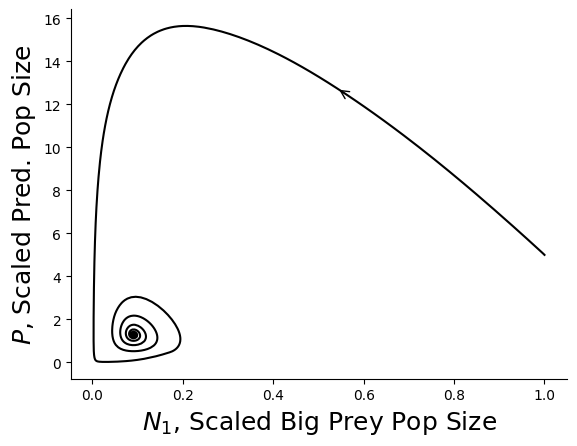

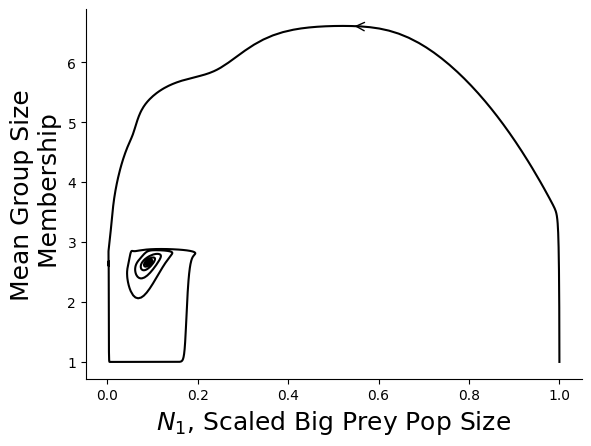

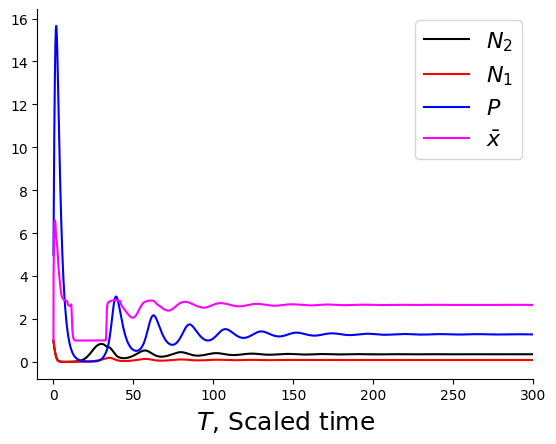

In [5]:
fig, ax = plot_x_vs_y(N1,P,N1lab,Plab,[90])
fig, ax = plot_x_vs_y(N1,mean_x,N1lab,mean_x_lab,[90])
fig, ax = plot_all(T,N1,N2,P,mean_x, xlim = [-10, 300])

(0.0, 10.0)

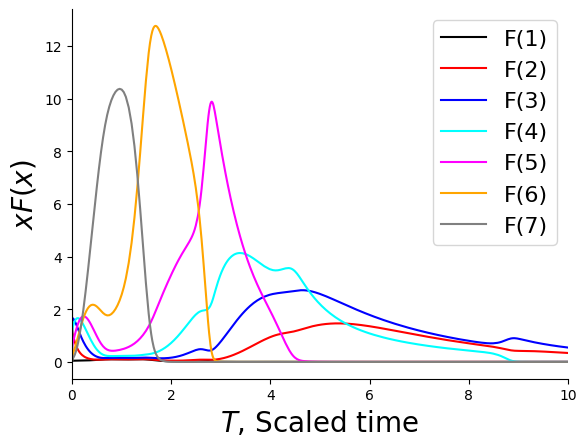

In [6]:
F_of_x_vec = out2.y[3:]
fig, ax = plt.subplots(1,1)
plot_xF(ax, out2, x_max, xlim = [-1,400])
plt.xlim([0,10])

(0.0, 3.1)

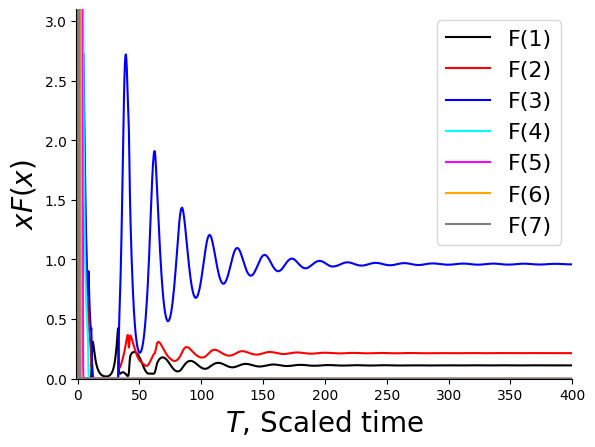

In [7]:
F_of_x_vec = out2.y[3:]
fig, ax = plt.subplots(1,1)
plot_xF(ax, out2, x_max, xlim = [-1,400])
plt.ylim([0,3.1])

# Type II: Comparing Fast and Slow Group Dynamics

In [9]:
H=2
x_max = 10
params_pop1 = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 10, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, ξ = 2, d = 100,
                 Tx = 0.01, r = 0, γ = 0, pop_process = True)

print_param_caption(**params_pop1)

The parameters are $\xi = 2, \eta_1 = 0.2, \eta_2 = 0.4, A_1 = 0.5, \beta_1 = 10, \beta_2 = 1, H_1 = 2, H_2 = 2, T_x = 0.01, \alpha_1(1) = 0.05, s_1 =2$, and $\alpha_2(x) = 0.95$ is constant.


In [41]:
P_reg = 5; N1_reg = 1; N2_reg = 1
F_of_x_vec = np.zeros(x_max)
x=1
F_of_x_vec[x-1] = P_reg/x
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec];

## Fast Group Dynamics

In [8]:
params = params_pop1.copy()
params['Tx' ] = 0.01
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]; 
t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
T, N1, N2, P, mean_x = get_results(out2, x_max)


NameError: name 'P_reg' is not defined

In [43]:
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]; 
t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
T, N1, N2, P, mean_x = get_results(out2, x_max)


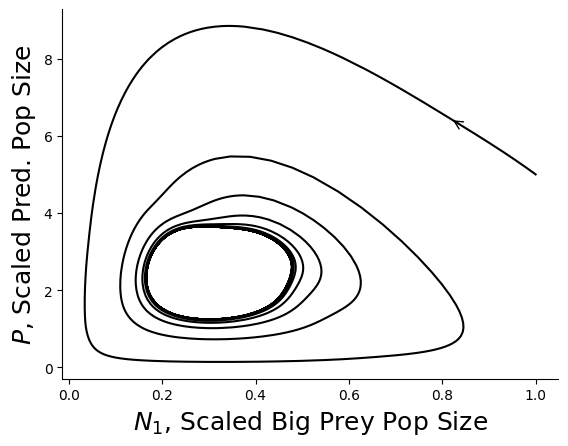

In [44]:
fig, ax = plot_x_vs_y(N1,P,N1lab,Plab,[90])

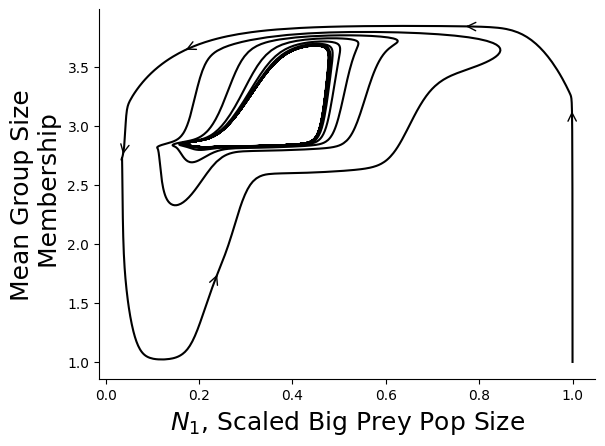

In [49]:
fig, ax = plot_x_vs_y(N1,mean_x,N1lab,mean_x_lab,[40,100,140, 225, 390])
fig.savefig(final_fig_path + 'params_pop1_plot_N1_vs_meanx.png', bbox_inches = 'tight')

In [15]:
plot_xF?

Signature: plot_xF(ax, out, x_max, xlim=[-1, 500])
Docstring:
plots time vs x*F(x)
@inputs
ax is the axis that is already made
out is the output of solve_ivp

@ returns: fig, ax
File:      /var/folders/qd/9pxy4gkx37575w3vclv1xfk40000gp/T/ipykernel_55047/4122371281.py
Type:      function

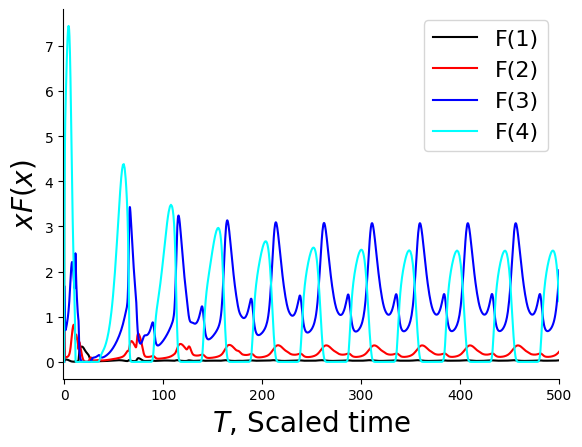

In [16]:
fig, ax  = plt.subplots(1,1)
F_of_x_vec = out2.y[3:]
plot_xF(ax, out2, x_max, xlim = [-1,500])

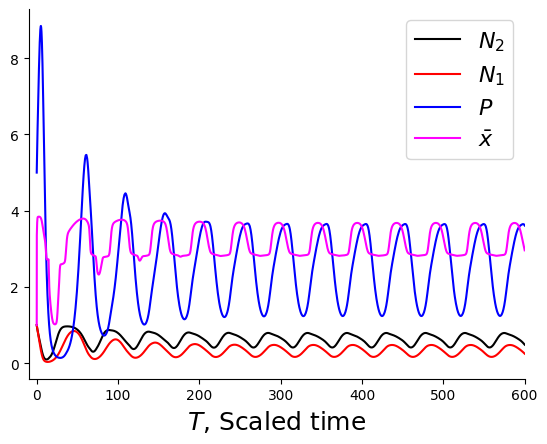

In [48]:
fig, ax = plot_all(T,N1,N2,P,mean_x, xlim = [-10, 600])
fig.savefig(final_fig_path + 'params_pop1_plotall.png', bbox_inches = 'tight')

## Slow Timescale

In [18]:
params = params_pop1.copy()
params['Tx'] = 1

In [19]:
params = params_pop1
t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))

T_slow, N1_slow, N2_slow, P_slow, mean_x_slow = get_results(out2, x_max)

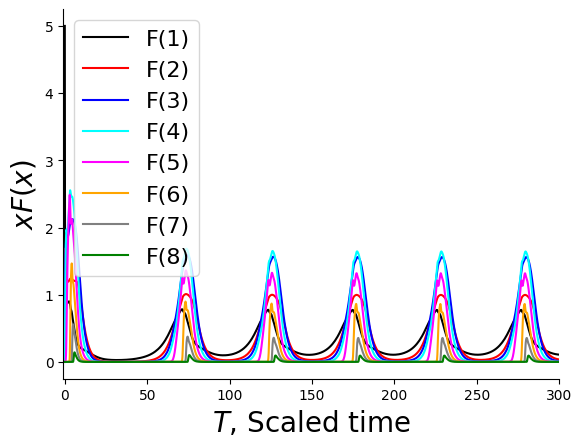

In [21]:
fig, ax  = plt.subplots(1,1)
F_of_x_vec = out2.y[3:]
plot_xF(ax, out2, x_max, xlim = [-1,300])

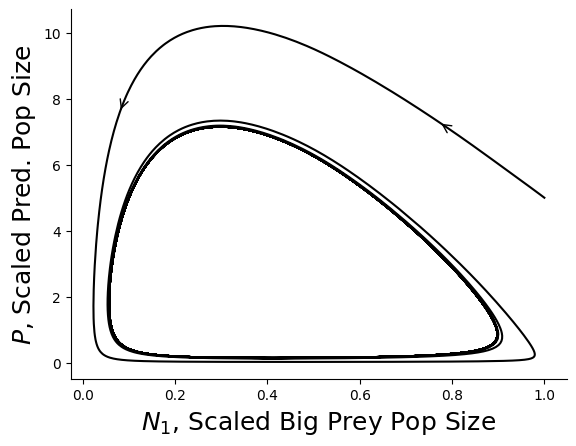

In [22]:
fig, ax = plot_x_vs_y(N1_slow, P_slow, N1lab, Plab, [50,150])


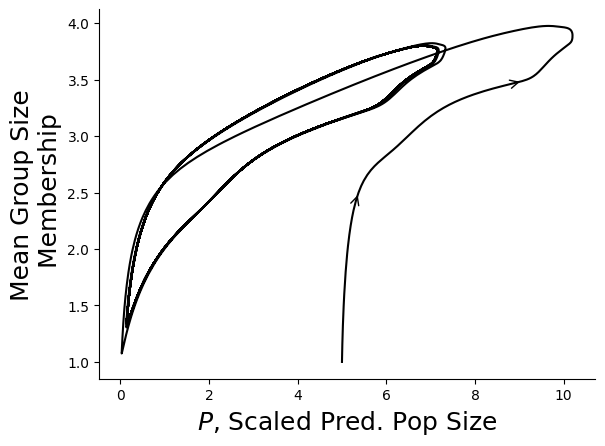

In [23]:
fig, ax = plot_x_vs_y(P_slow, mean_x_slow, Plab, mean_x_lab, [30,70])


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

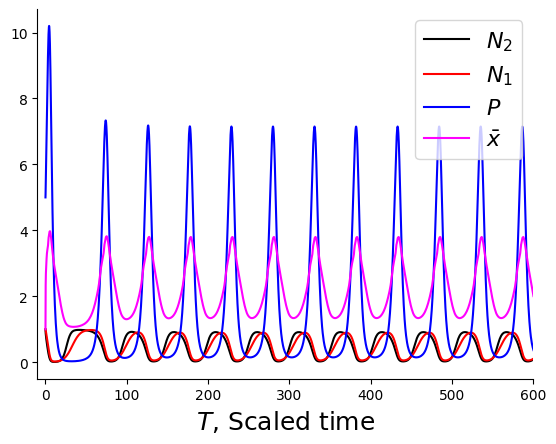

In [24]:
plot_all(T_slow, N1_slow, N2_slow, P_slow, mean_x_slow)

## very slow

In [25]:
params = params_pop1.copy()
params['Tx'] = 10

In [26]:
t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
T_slow2, N1_slow2, N2_slow2, P_slow2, mean_x_slow2 = get_results(out2, x_max)


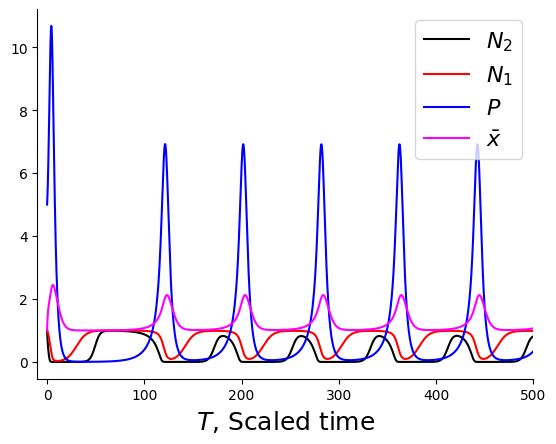

In [27]:
fig, ax = plot_all(T_slow2, N1_slow2, N2_slow2, P_slow2, mean_x_slow2, xlim = [-10,500])

## No Group Dynamics

### x = 1

In [32]:
final_fig_path

'../CH_popdyn_manuscript/Figures/'

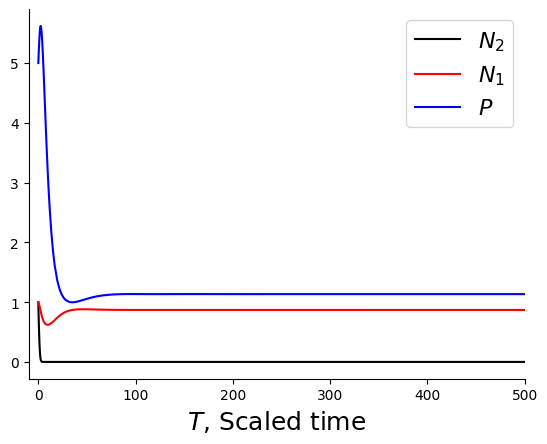

In [31]:
params = params_pop1.copy()

x=1

t_f=1000  

out2 = solve_ivp(model_one_x, [0, t_f], initialstate[:3], method="LSODA",
                args=(x,params))
#T, N1, N2, P, mean_x = get_results(out2, x_max)
T = out2.t
P, N1, N2 = out2.y
fig, ax = plot_all(T, N1, N2, P, mean_x = None,xlim = [-10,500])
fig.savefig(final_fig_path + 'params_pop1_onex_1_plotall.png',bbox_inches = 'tight') 

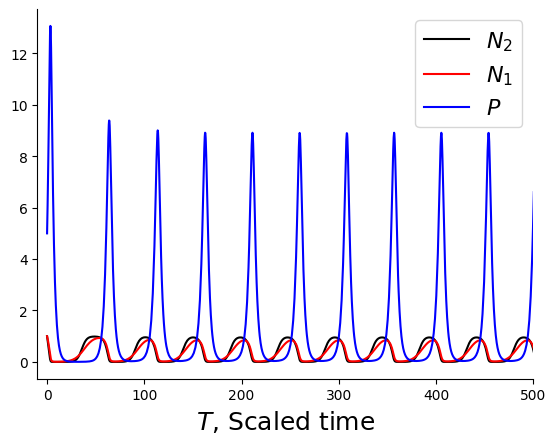

In [36]:
params = params_pop1.copy()

x=2

t_f=1000  

out2 = solve_ivp(model_one_x, [0, t_f], initialstate[:3], method="LSODA",
                args=(x,params))
#T, N1, N2, P, mean_x = get_results(out2, x_max)
T = out2.t
P, N1, N2 = out2.y
fig, ax = plot_all(T, N1, N2, P, mean_x = None,xlim = [-10,500])
fig.savefig(final_fig_path + 'params_pop1_onex_2_plotall.png',bbox_inches = 'tight') 

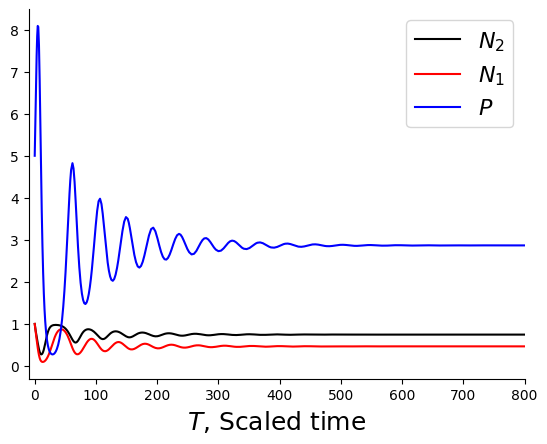

In [38]:
params = params_pop1.copy()

x=4

t_f=1000  

out2 = solve_ivp(model_one_x, [0, t_f], initialstate[:3], method="LSODA",
                args=(x,params))
#T, N1, N2, P, mean_x = get_results(out2, x_max)
T = out2.t
P, N1, N2 = out2.y
fig, ax = plot_all(T, N1, N2, P, mean_x = None,xlim = [-10,800])
fig.savefig(final_fig_path + 'params_pop1_onex_4_plotall.png',bbox_inches = 'tight')

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

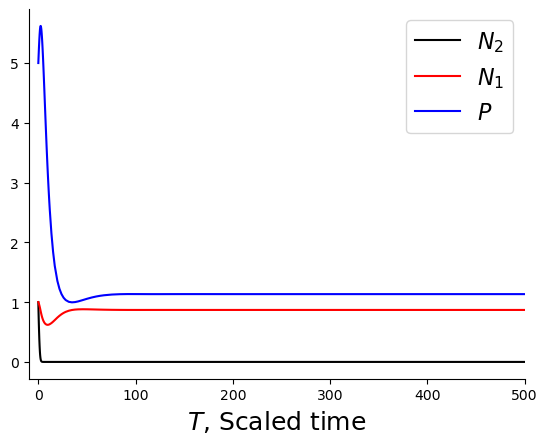

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

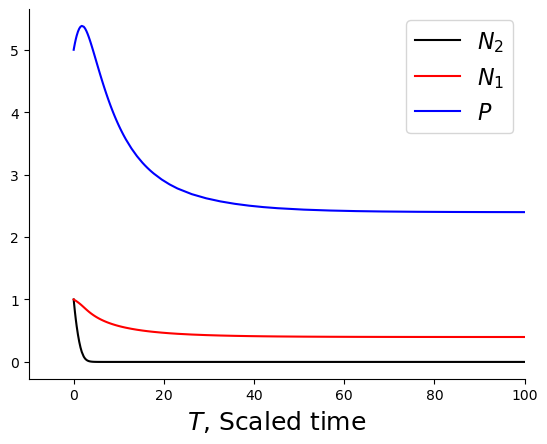

In [81]:
F_of_x_vec = np.zeros(x_max)
x=10
F_of_x_vec[x-1] = P_reg/x
initialstate[3:] = F_of_x_vec


t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(False,params))
T, N1, N2, P, mean_x = get_results(out2, x_max)
plot_all(T_x1, N1_x1, N2_x1, P_x1, mean_x = None,xlim = [-10,100])

In [42]:
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(False,params))

In [ ]:
P_x2, N1_x2, N2_x2 = out2.y[0:3]
F_of_x_vec_x2 = out2.y[3:]
mean_x_x2 = mean_group_size_membership(F_of_x_vec_slow.T, 10, P_slow)
T_x1 = out2.t

# Situation in which solitary hunters don't overhunt small prey

In [60]:
H=2
x_max = 10
params_pop2 = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, ξ = 2, d = 100,
                 Tx = .01, r = 0, γ = 0, pop_process = True)

In [61]:
P_reg = 5; N1_reg = 1; N2_reg = 1
F_of_x_vec = np.zeros(x_max)
x=1
F_of_x_vec[x-1] = P_reg/x
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec];

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

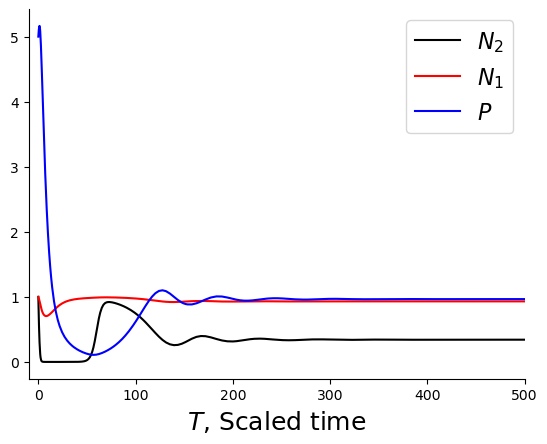

In [62]:
params = params_pop2.copy()
x=1

t_f=1000  

out2 = solve_ivp(model_one_x, [0, t_f], initialstate[:3], method="LSODA",
                args=(x,params))
#T, N1, N2, P, mean_x = get_results(out2, x_max)
T = out2.t
P, N1, N2 = out2.y
plot_all(T, N1, N2, P, mean_x = None,xlim = [-10,500])

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

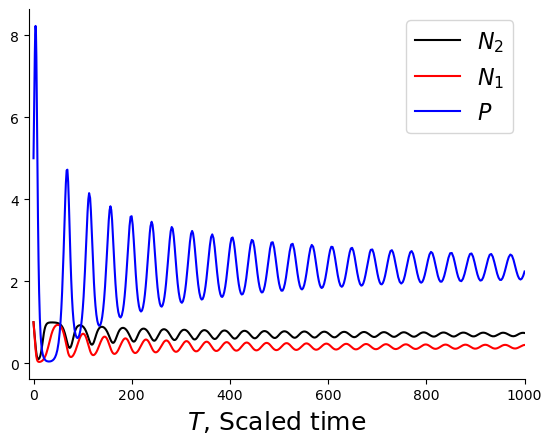

In [70]:
params = params_pop2.copy()
x=3

t_f=1000  

out2 = solve_ivp(model_one_x, [0, t_f], initialstate[:3], method="LSODA",
                args=(x,params))
#T, N1, N2, P, mean_x = get_results(out2, x_max)
T = out2.t
P, N1, N2 = out2.y
plot_all(T, N1, N2, P, mean_x = None,xlim = [-10,1000])

In [72]:
params = params_pop2.copy()
params['Tx'] = .01
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]; 
t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
T, N1, N2, P, mean_x = get_results(out2, x_max)

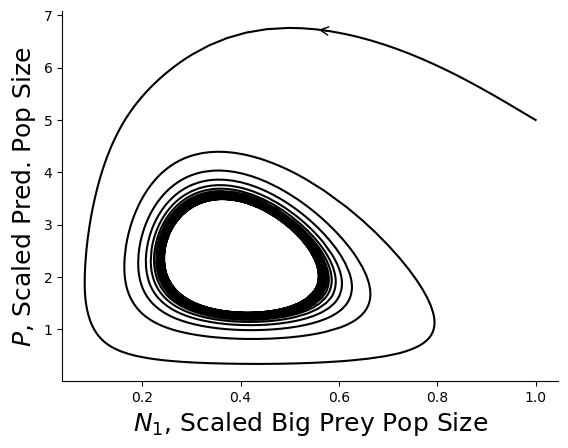

In [78]:
fig, ax = plot_x_vs_y(N1,P,N1lab,Plab,[120])

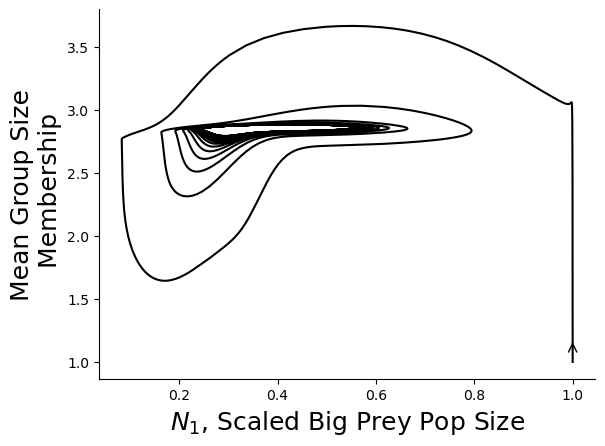

In [82]:
fig, ax = plot_x_vs_y(N1,mean_x, N1lab,mean_x_lab,[10])

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

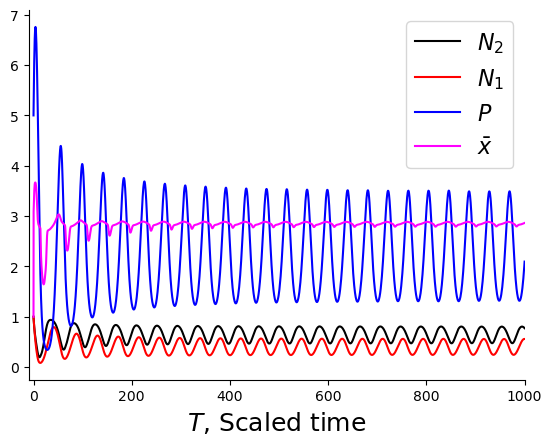

In [74]:
plot_all(T, N1, N2, P, mean_x, xlim = [-10,1000])

In [ ]:
fig, ax = plot_x_vs_y(N1,P,N1lab,Plab,[90])

# Sigmoidal capture probability of small prey

In [88]:
H=2
x_max = 10
params_pop3 = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 10, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'sigmoid',
                  x_max = x_max, ξ = 2, d = 100,
                 Tx = .1, r = 0, γ = 0, pop_process = True)

In [90]:
params = params_pop3.copy()
params['Tx'] = .01
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]; 
t_f=1000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
T, N1, N2, P, mean_x = get_results(out2, x_max)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

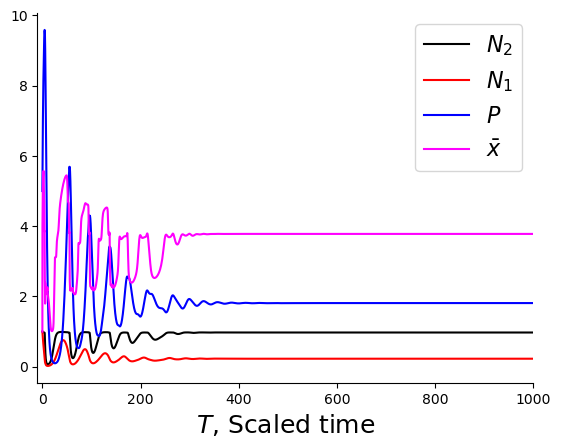

In [91]:
plot_all(T, N1, N2, P, mean_x, xlim = [-10,1000])

In [111]:
xvec = np.arange(1,11,1)

F_of_x_vec = out2.y[3:]

xF = xvec*F_of_x_vec.T

Text(0.5, 0, '$T$, Scaled time')

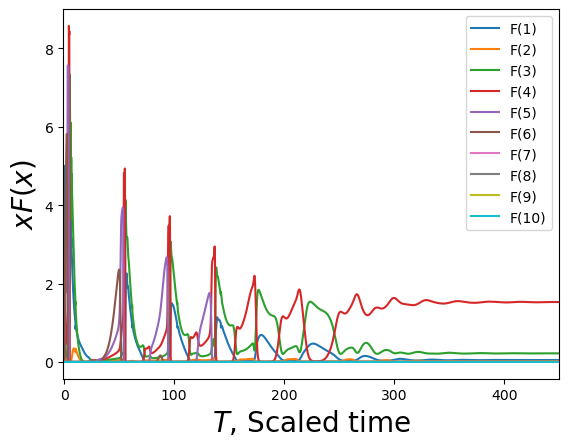

In [125]:
labels = [f'F({x})' for x in xvec]
p = plt.plot(T,xF, label=labels)
plt.legend()
plt.xlim([-1,450])
plt.ylabel(r'$xF(x)$', fontsize = 20)
plt.xlabel(Tlab, fontsize = 20)

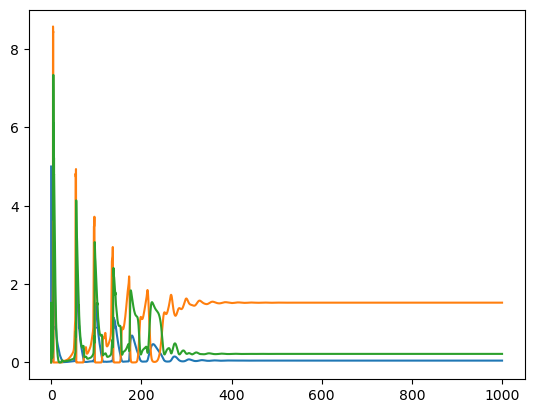

In [110]:
F_of_1 = F_of_x_vec[0]
p = plt.plot(T, F_of_1)
x=4
F_of_4= F_of_x_vec[x-1]
p = plt.plot(T, x*F_of_4)

x=3
p = plt.plot(T, x*F_of_x_vec[x-1])

In [ ]:
)